<a href="https://colab.research.google.com/github/Morpheus054/Basic_ML/blob/main/PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("./train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("./test.csv")

# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# preview test data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# check missing values in train data
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%


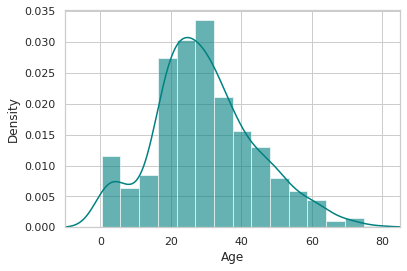

In [ ]:
#~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [ ]:
#Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values.

# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [ ]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


In [ ]:
#77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise. We'll ignore this variable in our model.

In [ ]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


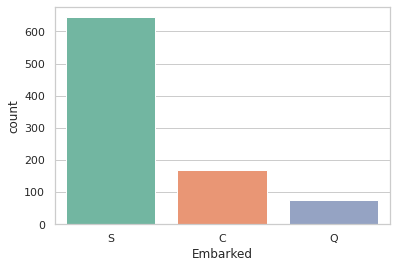

In [ ]:
#There are only 2 (0.22%) missing values for "Embarked", so we can just impute with the port where most people boarded.
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

In [ ]:
#By far the most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S".

Therefore based on the assessment of the missing values in the dataset, I'll make the following changes to the data:

- If "Age" is missing for a given row, I'll impute with 28 (median age).
- If "Embarked" is missing for a riven row, I'll impute with "S" (the most common boarding port).
- I'll ignore "Cabin" as a variable. There are too many missing values for imputation. Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [ ]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [ ]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family. For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

In [ ]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

In [ ]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])
training.drop('Sex_female', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,1


Now, we will apply the same changes to the test data.

I will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28).

I'll also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis.

There were no missing values in the "Embarked" port variable.
I'll add the dummy variables to finalize the test set.
Finally, I'll impute the 1 missing value for "Fare" with the median, 14.45.

In [ ]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
test_data = test_df.copy()
test_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna=True), inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

test_data['TravelAlone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

test_data.drop('SibSp', axis=1, inplace=True)
test_data.drop('Parch', axis=1, inplace=True)

testing = pd.get_dummies(test_data, columns=["Pclass","Embarked","Sex"])
testing.drop('Sex_female', axis=1, inplace=True)
testing.drop('PassengerId', axis=1, inplace=True)
testing.drop('Name', axis=1, inplace=True)
testing.drop('Ticket', axis=1, inplace=True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_male
0,34.5,7.8292,1,0,0,1,0,1,0,1
1,47.0,7.0000,0,0,0,1,0,0,1,0
2,62.0,9.6875,1,0,1,0,0,1,0,1
3,27.0,8.6625,1,0,0,1,0,0,1,1
4,22.0,12.2875,0,0,0,1,0,0,1,0


## EXPLORATION DATA ANALYSIS 

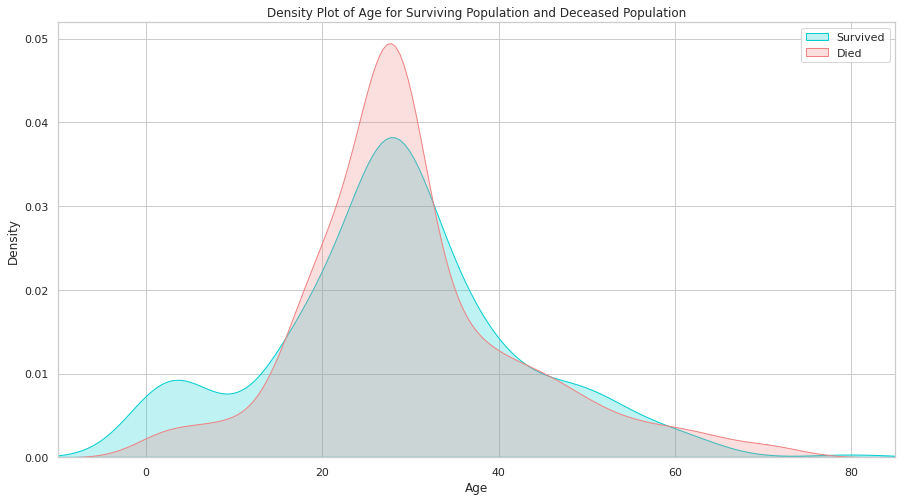

In [ ]:
#Exploration of Age
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [ ]:
#The age distribution for survivors and deceased is actually very similar. One notable difference is that, of the survivors, a larger proportion were children. The passengers evidently made an attempt to save children by giving them a place on the life rafts.

In [ ]:
#Considering the survival rate of passengers under 16, I'll also include another categorical variable in my dataset: "Minor"
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)

final_test['IsMinor']=np.where(final_test['Age']<=16, 1, 0)

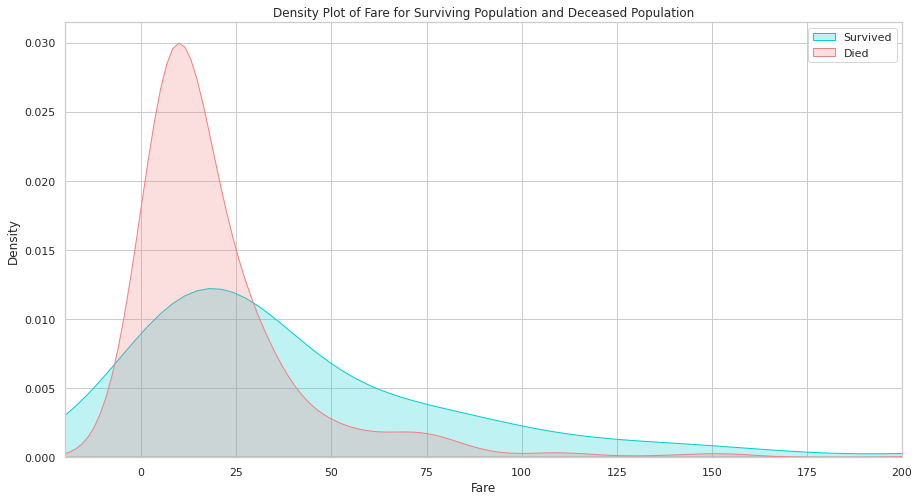

In [ ]:
#Exploration of Fare
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

In [ ]:
#As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model. Passengers who paid lower fare appear to have been less likely to survive. 

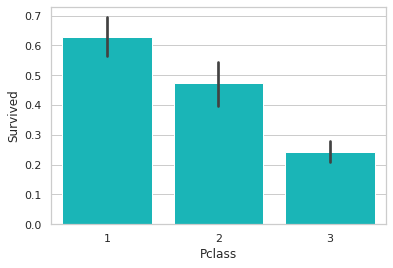

In [ ]:
#Exploration of Passenger Class
sns.barplot('Pclass', 'Survived', data=train_df, color="darkturquoise")
plt.show()

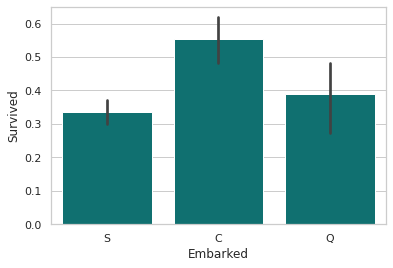

In [ ]:
#Exploration of Embarked Port
sns.barplot('Embarked', 'Survived', data=train_df, color="teal")
plt.show()

In [ ]:
#Passengers who boarded in Cherbourg, France, appear to have the highest survival rate. Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown.

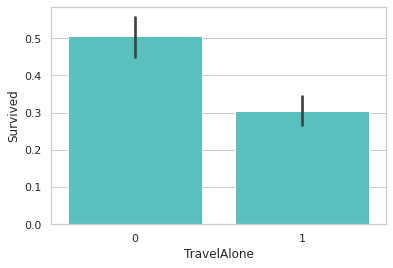

In [ ]:
#Exploration of Traveling Alone vs. With Family
sns.barplot('TravelAlone', 'Survived', data=final_train, color="mediumturquoise")
plt.show()

In [ ]:
#Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

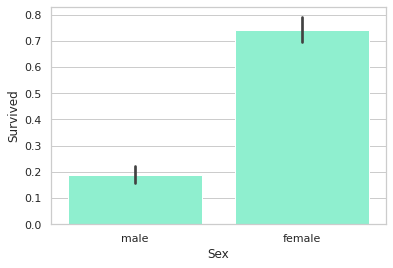

In [ ]:
#Exploration of Gender Variable
sns.barplot('Sex', 'Survived', data=train_df, color="aquamarine")
plt.show()

In [ ]:
#This is a very obvious difference. Clearly being female greatly increased your chances of survival.

## Model evaluation based on simple logisitc regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# create X (features) and y (response)
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
print('Train/Test split results:')
print("Accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print("Loss is %2.3f" % log_loss(y_test, y_pred_proba))

Train/Test split results:
Accuracy is 0.782
Loss is 0.504
